## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import os
import tqdm

In [2]:
na_pots=['no_potential','na_contacts','na_contacts_02avg','na_contacts_04avg','na_contacts_06avg','na_contacts_08avg','na_contacts_avg','na_contacts_px0']

## Tune hyperparameters

In [13]:
from Bio.PDB.PDBParser import PDBParser 
parser=PDBParser()

import warnings
warnings.simplefilter("ignore")

In [ ]:
structure=parser.get_structure('str',f'input_pdbs/1M5X.pdb')
atoms=[x['CA'] for x in structure[0]['A']]
coords1=[atom.get_coord() for atom in atoms]
coords1=np.array(coords1)

coords2=[atom.get_coord() for atom in structure[0]['C'].get_atoms()] + [atom.get_coord() for atom in structure[0]['D'].get_atoms()]
coords2=np.array(coords2)

dists=((coords1[None,:,:]-coords2[:,None,:])**2).sum(-1)

In [15]:
counts, bins = np.histogram(np.sqrt(dists.min(0)), bins=np.arange(0,25))

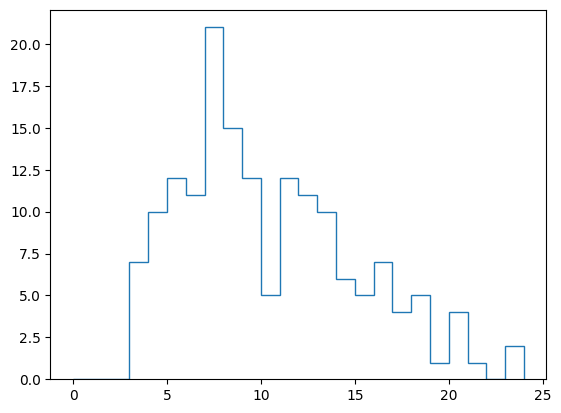

In [6]:
plt.stairs(counts, bins)
plt.show()

Text(0, 0.5, 'loss')

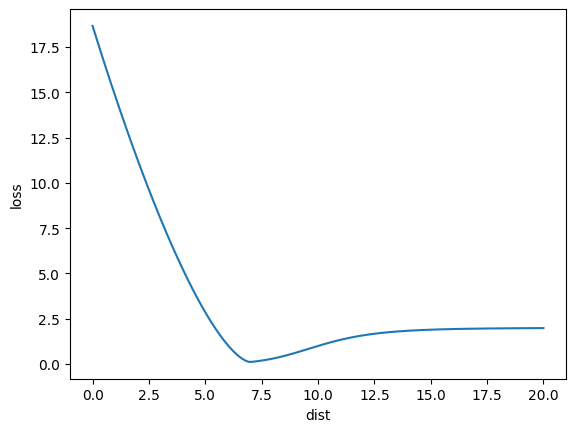

In [4]:
s=2
r_0=8
rep_r_0=7
rep_s=2
d_0=2


def contact_energy(dgram, d_0=d_0, r_0=r_0):
    divide_by_r_0 = (dgram - d_0) / r_0
    numerator = divide_by_r_0**6
    denominator = divide_by_r_0**12
    
    ncontacts = (1 - numerator) / ((1 - denominator))
    return 1 - ncontacts

def poly_repulse(dgram, r=rep_r_0, slope=rep_s, p=1.5):
    a = slope / (p * r**(p-1))
    return (dgram < r) * a * abs(r - dgram)**p * slope

def final(dgram, s=s):
    return s * contact_energy(dgram) + poly_repulse(dgram)


r = np.linspace(0.0,20.0,200)
plt.plot(r,final(r))
plt.xlabel('dist')
plt.ylabel('loss')

## Analyze trjectories

In [ ]:

def parse_log_file(log_file, 
                   p=['imsoi'], 
                   loss_name='NA CONTACT LOSS'):
    
    titles=[]
    steps=[]
    step=[]
    nis=[]
    ni=[]
    with open(log_file,'r') as f:
        for line in f:
            if line.strip().split(' ')[0] in p:
                titles.append(line.strip())
                steps.append([])
                nis.append([])
            elif line.startswith(loss_name):
                ni.append(float(line.split(': ')[1].replace('tensor(','').split(', ')[0]))
            elif 'Timestep' in line:
                step.append(int(line.split('Timestep ')[1].split(', ')[0]))
                if len(step)>1 and step[-1]==50:
                    step=step[-1:]
                    ni=ni[-1:]                  
                if step[-1]==2:
                    steps[-1].append(step)
                    nis[-1].append(ni)
                    step=[]
                    ni=[]
    for i in range(len(titles)):
        print(len(steps[i]))
        steps[i]=np.array(steps[i])
        nis[i]=np.array(nis[i])


    return titles, steps, nis

def show_dynamics(titles,steps,iis,color_dict, val=None):
    prots=set(list([' '.join(title.split(' ')[:-1]) for title in titles]))
    prots={x: i for i, x in enumerate(prots)}
    l=len(prots)
    plt.figure(figsize=(min(l*7.5,18),5))
    for i, title in enumerate(titles):
        prot=' '.join(title.split(' ')[:-1])
        label=title.split(' ')[-1]
        plt.subplot(1,l,prots[prot]%l+1)
        if val!=None and label not in val:
            continue
        for j in range(len(steps[i])):
            plt.plot(steps[i][j], iis[i][j][:len(steps[i][j])],
                     alpha=0.1, linewidth=0.5, color=color_dict[title.split(' ')[-1]])
            

    for i, title in enumerate(titles):
        prot=' '.join(title.split(' ')[:-1])
        label=title.split(' ')[-1]
        plt.subplot(1,l,prots[prot]%l+1)
        plt.title(prot)
        if val!=None and label not in val:
            continue
        try:
            plt.plot(steps[i][0], iis[i].mean(axis=0),
                     alpha=1, linewidth=1.5, color=color_dict[title.split(' ')[-1]],
                     label=label)
            plt.legend()
            plt.xlabel('Timestep')
            if i%l==0:
                plt.ylabel('Loss')
            plt.xlim((50,0))
            plt.ylim((0,int(max([ii.mean(axis=0) for ii in iis]))+0.1))
        except:
            pass

        
    plt.show()
    

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
0
50
50
50
50
50
50
50
0
50
50
3
2
2
1
0
0
0
0
0
50
0
50
0
50
50
50
50
50
50
50
0
52
50
50
50
50
50
50
50


/tmp/ipykernel_572508/842676970.py:68: RuntimeWarning: Mean of empty slice.
  plt.ylim((0,int(max([ii.mean(axis=0) for ii in iis]))+0.1))
/home/domain/geraseva/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


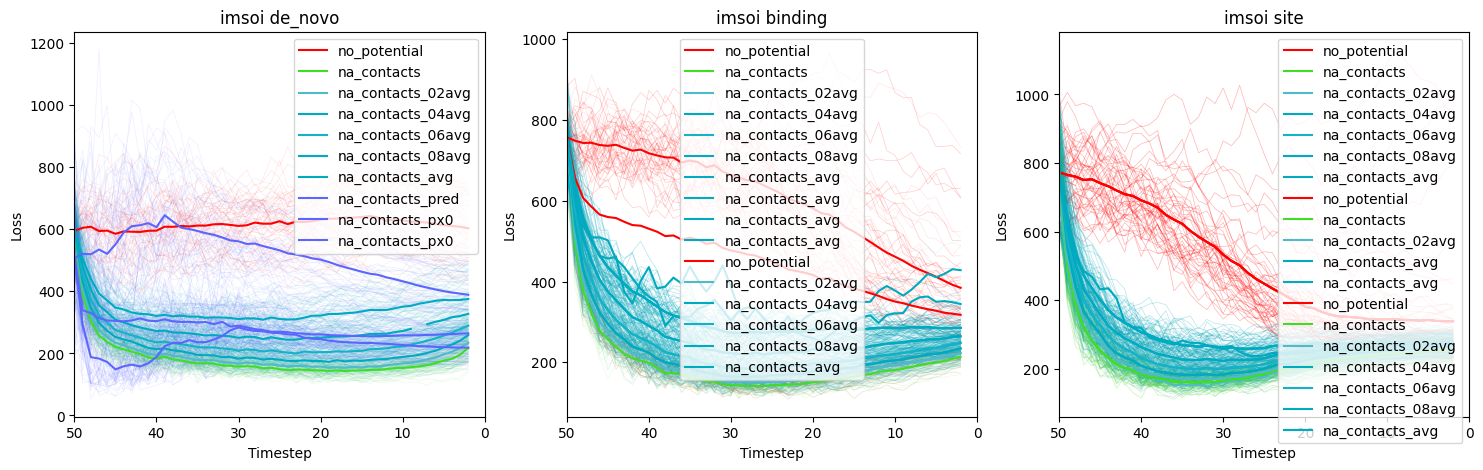

In [ ]:
titles, steps, nis=parse_log_file('example_outputs/na/rfdiffusion_outputs/test_na.log')

show_dynamics(titles,steps,nis,
              color_dict={'no_potential': '#FF0000',
                          'na_contacts': "#41DD22",
                          'na_contacts_02avg': "#4FBAC9",
                          'na_contacts_04avg': "#00AAC0",
                          'na_contacts_06avg': "#13B2C7",
                          'na_contacts_08avg': "#00AAC0",
                          'na_contacts_avg': "#00AAC0",
                          'na_contacts_px0': "#5B65FF"})

## Check clashes

In [9]:
from Bio.PDB.PDBParser import PDBParser 
parser=PDBParser()

import warnings
warnings.simplefilter("ignore")

In [ ]:
threshold=1.7
int_thr=7
arr=[]
for motif in ['de_novo','site','binding']:
    if not os.path.isdir(f'example_outputs/na/rfdiffusion_outputs/{motif}'):
        continue
    for potential in na_pots:
        if not os.path.isdir(f'example_outputs/na/rfdiffusion_outputs/{motif}/{potential}'):
            continue
        for file in tqdm.tqdm(os.listdir(f'example_outputs/na/rfdiffusion_outputs/{motif}/{potential}')):
            if 'na' not in file:
                continue
            structure=parser.get_structure('str',f'example_outputs/na/rfdiffusion_outputs/{motif}/{potential}/{file.replace("_na","")}')
            atoms=structure[0]['A'].get_atoms()
            coords1=[atom.get_coord() for atom in atoms]
            atoms=structure[0]['A'].get_atoms()
            cas=np.array([atom.get_name()=='CA' for atom in atoms])
            coords1=np.array(coords1)
            ligand=parser.get_structure('str',f'example_outputs/na/rfdiffusion_outputs/{motif}/{potential}/{file}')
            atoms=ligand.get_atoms()
            coords2=[atom.get_coord() for atom in atoms]
            coords2=np.array(coords2)
            dists=((coords1[None,:,:]-coords2[:,None,:])**2).sum(-1).min(0)
            arr.append([potential,motif,file.replace("_na",""),(dists<(threshold**2)).sum(), (dists<(int_thr**2)).sum(), np.sqrt(dists[cas])])

            
clash_df=pd.DataFrame(columns=['potential','design_type','name','number_of_clashes', 'number_of_contacts', 'dists'],data=arr)
clash_df['any_clashes']=(clash_df.number_of_clashes>0)
clash_df['number_of_contacts']=clash_df.number_of_contacts-clash_df.number_of_clashes

clash_df.potential=clash_df.potential.apply(lambda x: x.replace('na_','substrate_'))
clash_df.potential=clash_df.potential.apply(lambda x: x.replace('_avg','_1avg'))

clash_df.drop(['name','dists'],axis=1).groupby(['design_type','potential'],sort=False).mean()  

100%|██████████| 151/151 [00:09<00:00, 15.34it/s]


number_of_clashes  number_of_contacts  \
design_type potential                                                         
de_novo     no_potential                          58.20              200.58   
            substrate_contacts                    14.08              157.38   
            substrate_contacts_02avg              12.84              147.08   
            substrate_contacts_04avg              15.38              141.02   
            substrate_contacts_06avg              15.66              129.08   
            substrate_contacts_08avg              15.26              121.56   
            substrate_contacts_1avg               18.98              111.74   
            substrate_contacts_px0                 1.76              101.20   
site        no_potential                          13.22              101.22   
            substrate_contacts                     0.68               49.72   
            substrate_contacts_02avg               1.18               48.10   
            substrate_contacts_04avg               0.62               44.28   
            substrate_contacts_06avg               0.56               41.66   
            substrate_contacts_08avg               0.40               37.76   
            substrate_contacts_1avg                0.74               37.38   
binding     no_potential                          18.06              206.60   
            substrate_contacts                     1.70              118.86   
            substrate_contacts_02avg               1.12              114.08   
            substrate_contacts_04avg               1.88              111.96   
            substrate_contacts_06avg               1.82              111.68   
            substrate_contacts_08avg               2.60              108.80   
            substrate_contacts_1avg                2.84              108.32   

                                      any_clashes  
design_type potential                              
de_novo     no_potential                     1.00  
            substrate_contacts               0.92  
            substrate_contacts_02avg         0.96  
            substrate_contacts_04avg         0.96  
            substrate_contacts_06avg         0.96  
            substrate_contacts_08avg         0.96  
            substrate_contacts_1avg          0.94  
            substrate_contacts_px0           0.30  
site        no_potential                     0.64  
            substrate_contacts               0.20  
            substrate_contacts_02avg         0.22  
            substrate_contacts_04avg         0.18  
            substrate_contacts_06avg         0.16  
            substrate_contacts_08avg         0.16  
            substrate_contacts_1avg          0.16  
binding     no_potential                     0.90  
            substrate_contacts               0.44  
            substrate_contacts_02avg         0.42  
            substrate_contacts_04avg         0.42  
            substrate_contacts_06avg         0.40  
            substrate_contacts_08avg         0.44  
            substrate_contacts_1avg          0.56

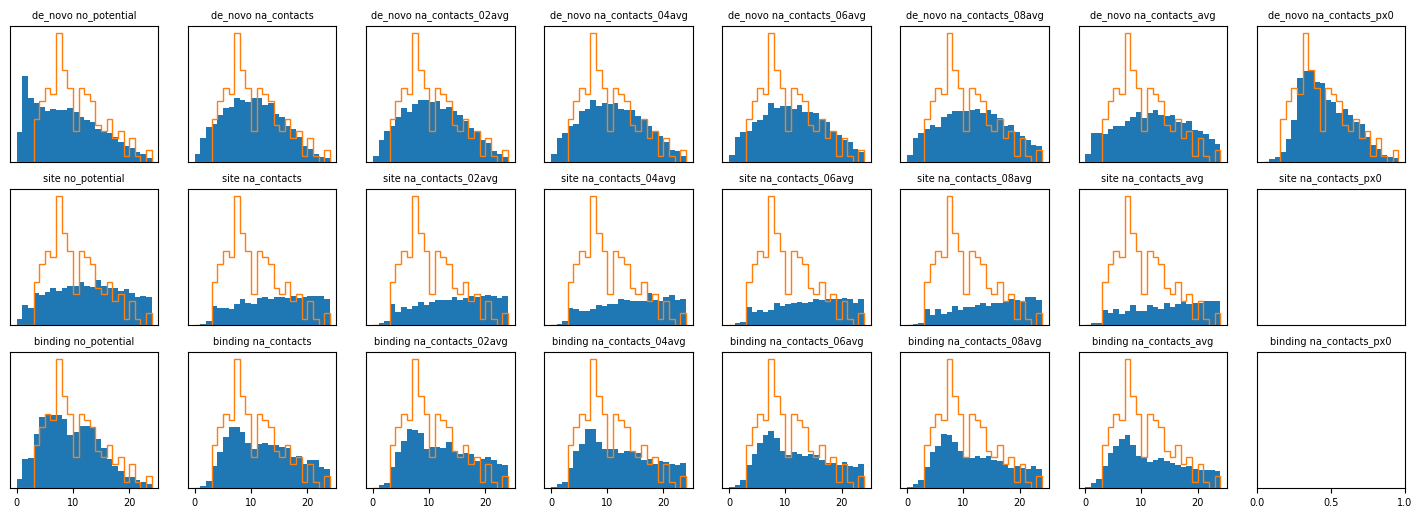

In [16]:
a=clash_df.groupby(['design_type','potential'],sort=False).dists.aggregate(lambda x: np.concatenate(tuple(x)))
plt.figure(figsize=(18,6))

for i, motif in enumerate(['de_novo','site','binding']):
    for j, potential in enumerate(na_pots):
        plt.subplot(3, len(na_pots),len(na_pots)*i+j+1)
        plt.title(motif+' '+potential, fontsize=7)
        try:
            plt.hist(a.loc[(motif,potential.replace('na_','substrate_').replace('_avg','_1avg'))], bins=np.arange(0,25))
            plt.stairs(counts*50, bins)
        except KeyError:
            pass
        if i<2:
            plt.xticks([])
        plt.xticks(fontsize=7)
        plt.yticks([])

plt.show()


In [17]:
clash_df.potential=clash_df.potential.apply(lambda x: x.replace('_','\n'))

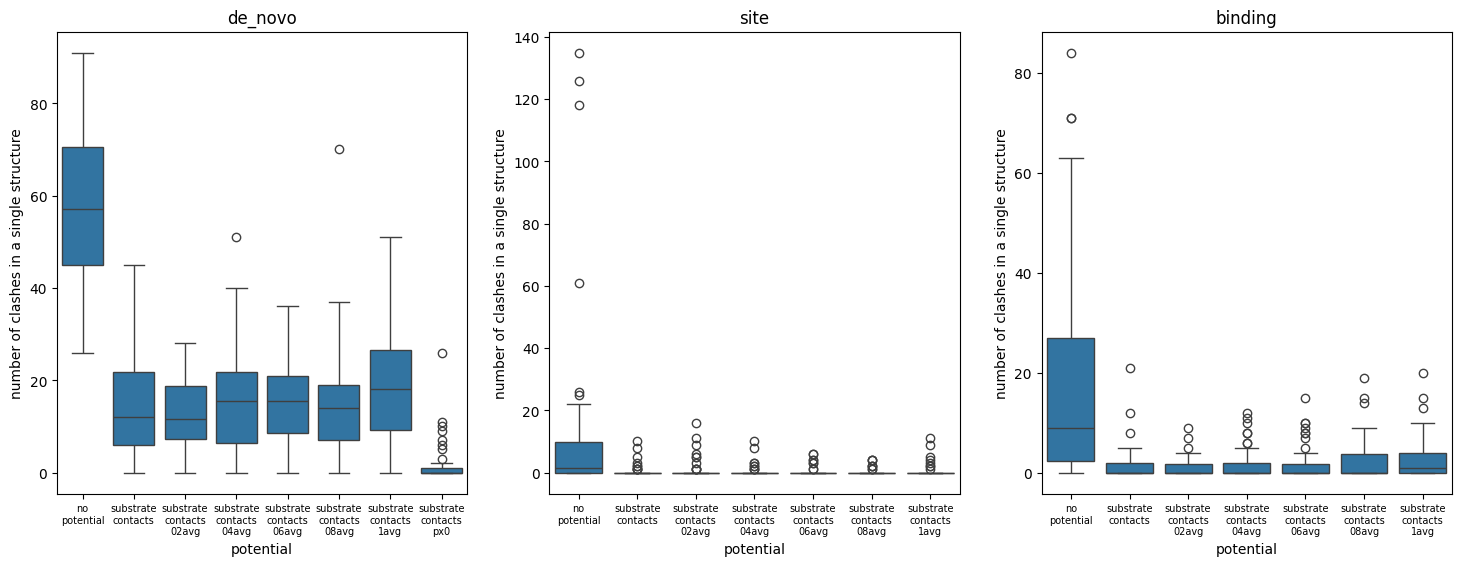

In [18]:
plt.figure(figsize=(18,6))
for i, motif in enumerate(['de_novo','site','binding']):
    plt.subplot(1,3,i+1)
    plt.title(motif)
    sns.boxplot(x="potential", y="number_of_clashes", hue="design_type",
                data=clash_df[clash_df.design_type==motif])
    plt.xlabel('potential')
    plt.xticks(fontsize=7)# rotation=20)

    plt.ylabel('number of clashes in a single structure')

    plt.legend().set_visible(False)
plt.show()

## Calculate DDG

In [19]:
#import importlib
#importlib.reload(pyrosetta)

from pyrosetta import *
from pyrosetta.rosetta import *
#from pyrosetta.toolbox import *
from pyrosetta.teaching import *

init("-mute all")

scorefxnDDG=get_fa_scorefxn()
fa_sol_score=ScoreFunction()
fa_sol_score.set_weight(fa_sol, 1.0)
interface_score=ScoreFunction()
interface_score.set_weight(interface_dd_pair, 1.0)

from multiprocessing import Pool, cpu_count
from IPython.display import clear_output


def calc_ddg(fs):
    testPose= Pose()
    testPose = pose_from_pdb(fs)
    ddg=scorefxnDDG(testPose)
    clear_output()
    return ddg

print(cpu_count())

PyRosetta-4 2022 [Rosetta PyRosetta4.Release.python310.ubuntu 2022.35+release.6079c70fa16855c06a9c2070a7085bf619df3065 2022-08-31T18:05:32] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
8


In [ ]:
for motif in ['de_novo','site','binding']:
    if not os.path.isdir(f'example_outputs/na/proteinmpnn_output/{motif}'):
        continue
    for potential in na_pots:
        if not os.path.isdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/'):
            continue
        if os.path.isdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_apo/'):
            continue
        os.system(f"mkdir example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_apo/")
        os.system(f"mkdir example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_na/")
        for file in os.listdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/'):
            if file[-3:]!='pdb':
                continue
            os.system(f"cat example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/{file}" + 
                      f" | egrep ' A ' > example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_apo/{file} ")
            os.system(f"cat example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/{file}" + 
                      f" | egrep -v ' A ' | sed 's/\ D\ /\ C\ /' > example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_na/{file} ")

In [ ]:
arr=[]
for motif in ['de_novo']:
    if not os.path.isdir(f'example_outputs/na/rfdiffusion_outputs/{motif}'):
        continue
    for potential in na_pots:
        if not os.path.isdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/'):
            continue
        for file in os.listdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/'):
            if file[-3:]!='pdb':
                continue
            arr.append([f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/{file}', 
                        f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_apo/{file}',
                        f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_na/{file}', 
                        file.split('.')[0],'_'.join(file.split('_')[:-2]),motif,potential])
        
        
str_df=pd.DataFrame(columns=['path_c','path_a','path_n', 'name','protein','design_type','potential'], 
                    data=arr)

with Pool(cpu_count()-2) as p:
    scores_c=np.array(list(tqdm.tqdm(p.imap(calc_ddg, str_df.path_c), total=len(str_df.path_c))))
    scores_a=np.array(list(tqdm.tqdm(p.imap(calc_ddg, str_df.path_a), total=len(str_df.path_a))))
    scores_n=np.array(list(tqdm.tqdm(p.imap(calc_ddg, str_df.path_n), total=len(str_df.path_n))))

str_df['ddg']=scores_c-(scores_a+scores_n)
str_df.drop('path_c', axis=1)
str_df.drop('path_a', axis=1)
str_df.drop('path_n', axis=1)

str_df

In [23]:
str_df.potential=str_df.potential.apply(lambda x: x.replace('na_','substrate_').replace('_avg','_1avg'))
str_df.potential=str_df.potential.apply(lambda x: x.replace('_','\n'))

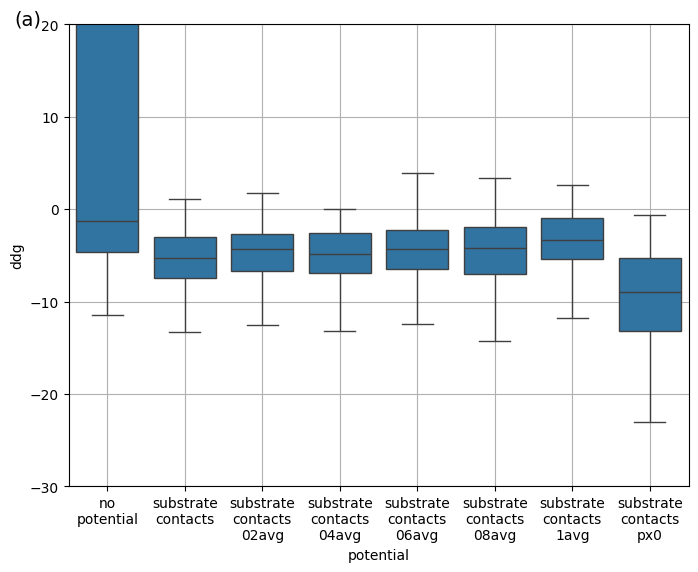

In [24]:
for i, motif in enumerate(['de_novo']):
    plt.figure(figsize=(8,6))
    #plt.title(motif)
    sns.boxplot(x="potential", y="ddg",
                data=str_df[str_df.design_type==motif], legend='full', showfliers=False)
    plt.xlabel('potential')
    plt.ylim(-30,20)
    plt.grid()
    #plt.xticks(rotation=20)
    plt.text(-1.2, 20, '(a)', fontsize=14)

    plt.show()

In [ ]:
arr=[]
for motif in ['site','binding']:
    if not os.path.isdir(f'example_outputs/na/rfdiffusion_outputs/{motif}'):
        continue
    for potential in na_pots[:2]:
        if not os.path.isdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/'):
            continue
        for file in os.listdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/'):
            if file[-3:]!='pdb':
                continue
            arr.append([f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/{file}', 
                        f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_apo/{file}',
                        f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_na/{file}', 
                        file.split('.')[0],'_'.join(file.split('_')[:-2]),motif,potential])
        
        
str_df=pd.DataFrame(columns=['path_c','path_a','path_n', 'name','protein','design_type','potential'], 
                    data=arr)

with Pool(cpu_count()-2) as p:
    scores_c=np.array(list(tqdm.tqdm(p.imap(calc_ddg, str_df.path_c), total=len(str_df.path_c))))
    scores_a=np.array(list(tqdm.tqdm(p.imap(calc_ddg, str_df.path_a), total=len(str_df.path_a))))
    scores_n=np.array(list(tqdm.tqdm(p.imap(calc_ddg, str_df.path_n), total=len(str_df.path_n))))

str_df['ddg']=scores_c-(scores_a+scores_n)
str_df.drop('path_c', axis=1)
str_df.drop('path_a', axis=1)
str_df.drop('path_n', axis=1)

str_df.potential=str_df.potential.apply(lambda x: x.replace('na_','substrate_').replace('_avg','_1avg'))
str_df.potential=str_df.potential.apply(lambda x: x.replace('_','\n'))




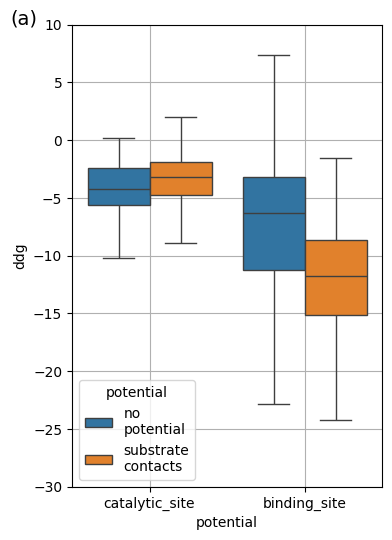

In [ ]:
plt.figure(figsize=(4,6))
#plt.title(motif)
sns.boxplot(x="design_type", y="ddg", hue='potential',
                data=str_df, legend='full', showfliers=False)
plt.xlabel('potential')
plt.ylim(-30,10)
plt.grid()
plt.xticks(ticks=[0,1],labels=['catalytic_site','binding_site'])
plt.text(-0.9, 10, '(a)', fontsize=14)

plt.show()

## GNINA scores

In [ ]:
for motif in ['de_novo','site','binding']:
    if not os.path.isdir(f'example_outputs/na/proteinmpnn_output/{motif}'):
        continue
    for potential in na_pots:
        if not os.path.isdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_apo/'):
            continue
        os.system(f"mkdir example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_docked/")
        for file in os.listdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_apo/'):
            if os.path.isfile(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_docked/{file}'):
                continue
            os.system(f"/home/domain/data/prog/micromamba/envs/drugflow/bin/gnina " + 
                      f"-r example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_apo/{file}" + 
                      f" -l example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_na/{file} --minimize " + 
                      f"-o example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_docked/{file} > logs/gnina_na.log")  

In [ ]:
arr=[]

for motif in ['de_novo','site','binding']:
    if not os.path.isdir(f'example_outputs/na/proteinmpnn_output/{motif}'):
        continue
    for potential in na_pots:
        if not os.path.isdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_docked/'):
            continue
        for file in tqdm.tqdm(os.listdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_docked/')):
            with open(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_docked/{file}','r') as f:
                pars=[]
                for i in range(5):
                    pars.append(float(f.readline().strip().split(' ')[-1]))
                arr.append([potential,motif,file]+pars[1:])
dock_df=pd.DataFrame(columns=['potential','design_type','file','minimizedAffinity','minimizedRMSD','CNNAffinity','CNNScore'],data=arr)
dock_df.head()

,potential,design_type,file,minimizedAffinity,minimizedRMSD,CNNAffinity,CNNScore
0,no_potential,de_novo,imsoi_9_2.pdb,-3.906693,12.956938,0.731586,5.868757
1,no_potential,de_novo,imsoi_38_5.pdb,-3.035295,3.787638,0.648568,7.825629
2,no_potential,de_novo,imsoi_33_1.pdb,-1.025963,7.316179,0.567136,7.660020
3,no_potential,de_novo,imsoi_20_4.pdb,-0.583203,6.279810,0.535269,7.568559
4,no_potential,de_novo,imsoi_19_2.pdb,-1.478300,10.758923,0.297723,8.029493


In [27]:
dock_df.potential=dock_df.potential.apply(lambda x: x.replace('na_','substrate_').replace('_avg','_1avg'))
dock_df.potential=dock_df.potential.apply(lambda x: x.replace('_','\n'))

de_novo


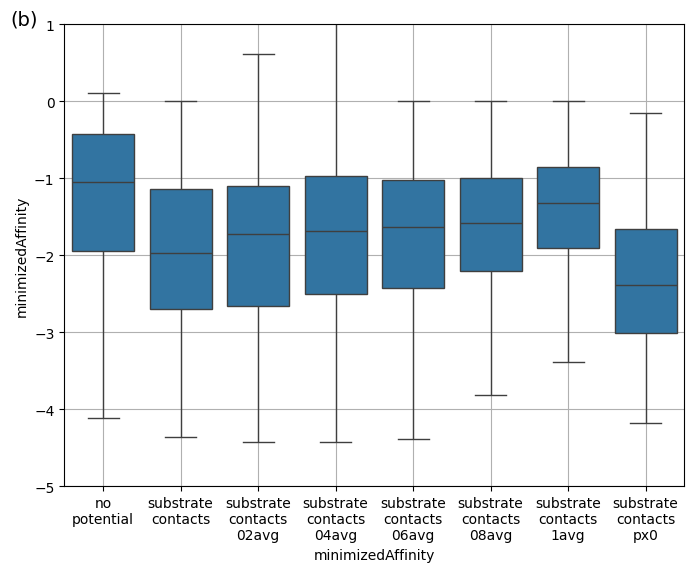

In [28]:
for i, motif in enumerate(['de_novo']):#,'site','binding']):
    plt.figure(figsize=(8,6))
    print(motif)
    #plt.title(motif)
    sns.boxplot(x="potential", y="minimizedAffinity",
                data=dock_df[dock_df.design_type==motif], legend='full', showfliers=False)
    plt.xlabel('minimizedAffinity')
    plt.ylim(-5,1)
    plt.grid()
    #plt.xticks(rotation=20)
    plt.text(-1.2, 1, '(b)', fontsize=14)

    plt.show()

In [ ]:
arr=[]

for motif in ['site','binding']:
    if not os.path.isdir(f'example_outputs/na/proteinmpnn_output/{motif}'):
        continue
    for potential in na_pots[:2]:
        if not os.path.isdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_docked/'):
            continue
        for file in os.listdir(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_docked/'):
            with open(f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed_docked/{file}','r') as f:
                pars=[]
                for i in range(5):
                    pars.append(float(f.readline().strip().split(' ')[-1]))
                arr.append([potential,motif,file]+pars[1:])
dock_df=pd.DataFrame(columns=['potential','design_type','file','minimizedAffinity','minimizedRMSD','CNNAffinity','CNNScore'],data=arr)

dock_df.potential=dock_df.potential.apply(lambda x: x.replace('na_','substrate_').replace('_avg','_1avg'))
dock_df.potential=dock_df.potential.apply(lambda x: x.replace('_','\n'))



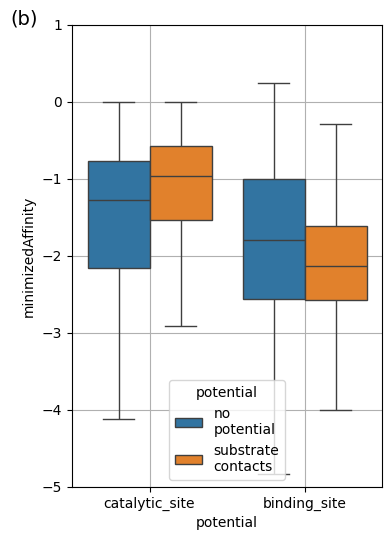

In [32]:
plt.figure(figsize=(4,6))
#plt.title(motif)
sns.boxplot(x="design_type", y="minimizedAffinity", hue='potential',
                data=dock_df, legend='full', showfliers=False)
plt.xlabel('potential')
plt.ylim(-5,1)
plt.grid()
plt.xticks(ticks=[0,1],labels=['catalytic_site','binding_site'])
plt.text(-0.9, 1, '(b)', fontsize=14)

plt.show()

## DMaSIF validation

In [ ]:
import json
surf_df=[]
for motif in ['de_novo','site','binding']:
    for potential in na_pots:
        try:
            with open(f'example_outputs/na/dmasif_output/{motif}/{potential}/meta.json','r') as f:
                info=json.load(f)
        except FileNotFoundError:
            continue
        surf_df.append(pd.DataFrame.from_dict(info))
        
        surf_df[-1]['potential']=potential
        surf_df[-1]['design_type']=motif

surf_df=pd.concat(surf_df)

surf_df['PDB IDs']=surf_df['PDB IDs'].apply(lambda x: x[0])
surf_df['protein']=surf_df['PDB IDs'].apply(lambda x: '_'.join(x.split('_')[:-2]))
surf_df = surf_df.reset_index(drop=True)

surf_df

,surf_time,ROC-AUC,Loss,R_values/conv,conv_time,PDB IDs,R_values/input,memory_usage,indexes,potential,design_type,protein
0,0,0.756482,0.589484,1.535392,0.026714,imsoi_0_1.pdb A CD,3.033811,504934912,imsoi_0_1.pdb A CD,no_potential,de_novo,imsoi
1,0,0.815060,0.517507,1.552793,0.019828,imsoi_0_2.pdb A CD,3.087147,504934912,imsoi_0_2.pdb A CD,no_potential,de_novo,imsoi
2,0,0.666483,0.698055,1.717255,0.019602,imsoi_0_3.pdb A CD,3.057804,504934912,imsoi_0_3.pdb A CD,no_potential,de_novo,imsoi
3,0,0.522793,0.944202,1.608178,0.019803,imsoi_0_4.pdb A CD,3.062991,504934912,imsoi_0_4.pdb A CD,no_potential,de_novo,imsoi
4,0,0.662458,0.718913,1.662498,0.019397,imsoi_0_5.pdb A CD,3.180645,504934912,imsoi_0_5.pdb A CD,no_potential,de_novo,imsoi
...,...,...,...,...,...,...,...,...,...,...,...,...
5495,0,0.941475,0.324076,1.537144,0.014620,imsoi_9_1.pdb A CD,2.999938,486385664,imsoi_9_1.pdb A CD,na_contacts_avg,binding,imsoi
5496,0,0.780591,0.562025,1.640080,0.014418,imsoi_9_2.pdb A CD,3.057201,486385664,imsoi_9_2.pdb A CD,na_contacts_avg,binding,imsoi
5497,0,0.724743,0.627132,1.705835,0.014051,imsoi_9_3.pdb A CD,3.052225,486385664,imsoi_9_3.pdb A CD,na_contacts_avg,binding,imsoi
5498,0,0.797684,0.563248,1.560479,0.014878,imsoi_9_4.pdb A CD,2.974009,486385664,imsoi_9_4.pdb A CD,na_contacts_avg,binding,imsoi


In [35]:
surf_df.potential=surf_df.potential.apply(lambda x: x.replace('na_','substrate_').replace('_avg','_1avg'))
surf_df.potential=surf_df.potential.apply(lambda x: x.replace('_','\n'))

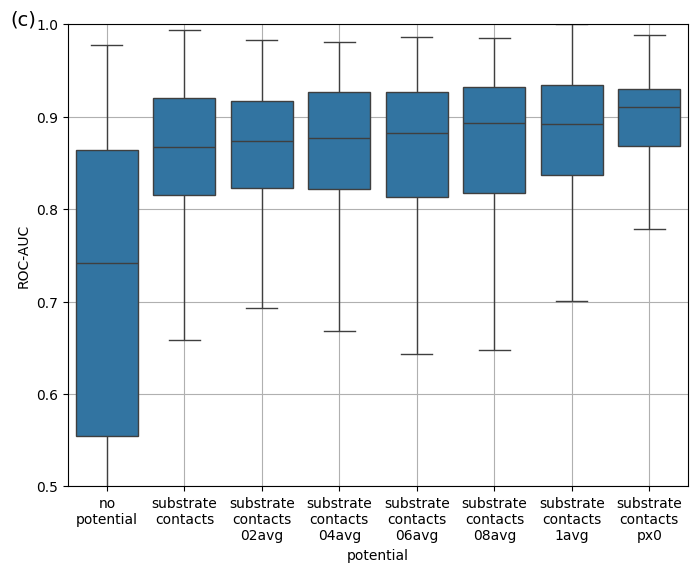

In [36]:
for i, motif in enumerate(['de_novo']):#,'site','binding']):

    plt.figure(figsize=(8,6))
    sns.boxplot(x="potential", y="ROC-AUC", hue="design_type",
                    data=surf_df[surf_df.design_type==motif], showfliers=False)
    plt.xlabel('potential')
    plt.ylim(0.5,1)

    plt.legend().set_visible(False)
    plt.grid()
    plt.text(-1.25, 1, '(c)', fontsize=14)

    plt.show()

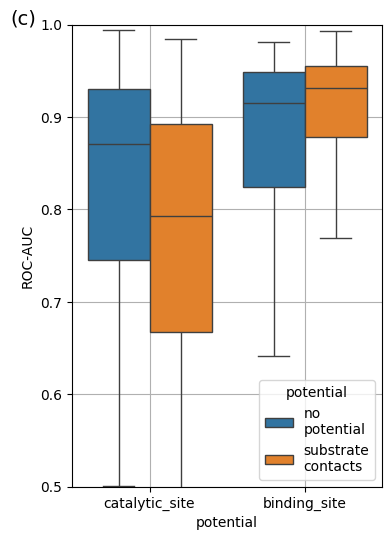

In [ ]:
import json
surf_df=[]
for motif in ['site','binding']:
    for potential in na_pots[:2]:
        try:
            with open(f'example_outputs/na/dmasif_output/{motif}/{potential}/meta.json','r') as f:
                info=json.load(f)
        except FileNotFoundError:
            continue
        surf_df.append(pd.DataFrame.from_dict(info))
        
        surf_df[-1]['potential']=potential
        surf_df[-1]['design_type']=motif

surf_df=pd.concat(surf_df)

surf_df['PDB IDs']=surf_df['PDB IDs'].apply(lambda x: x[0])
surf_df['protein']=surf_df['PDB IDs'].apply(lambda x: '_'.join(x.split('_')[:-2]))
surf_df = surf_df.reset_index(drop=True)

surf_df.potential=surf_df.potential.apply(lambda x: x.replace('na_','substrate_').replace('_avg','_1avg'))
surf_df.potential=surf_df.potential.apply(lambda x: x.replace('_','\n'))

plt.figure(figsize=(4,6))
#plt.title(motif)
sns.boxplot(x="design_type", y="ROC-AUC", hue='potential',
                data=surf_df, legend='full', showfliers=False)
plt.xlabel('potential')
plt.ylim(0.5,1)
plt.grid()
plt.xticks(ticks=[0,1],labels=['catalytic_site','binding_site'])
plt.text(-0.9, 1, '(c)', fontsize=14)

plt.show()

## Secondary structure analysis

In [ ]:
arr=[]
for motif in ['de_novo','site','binding']:
    for potential in na_pots:
        if not os.path.isdir(f'example_outputs/na/dssp_statistics/{motif}/{potential}/'):
            continue
        for file in tqdm.tqdm(os.listdir(f'example_outputs/na/dssp_statistics/{motif}/{potential}')):
            d={'H':0,'S':0,'T':0,'G':0,'B':0,'I':0,'E':0,' ':0}
            with open(f'example_outputs/na/dssp_statistics/{motif}/{potential}/{file}') as f:
                for s in f:
                    if s[-1]=='.':
                        continue
                    if s[11]!='A':
                        continue
                    d[s[16]]+=1
            arr.append([file.split('.')[0],'_'.join(file.split('_')[:-1]),potential, motif]+[d.get(x,0) for x in 'HSTGBIE '])
sec_df=pd.DataFrame(columns=['name','protein','potential','design_type','alpha\nhelix\n','bend',
                             'turn','3-10\nhelix','beta\nbridge','pi\nhelix','beta\nsheet','other'], 
                    data=arr)
cols2sum=sec_df.select_dtypes(include=['int64']).columns[(sec_df.select_dtypes(include=['int64']) < 25).all()]
sec_df['other']=sec_df['other']+sec_df[cols2sum].sum(axis=1)
sec_df=sec_df.drop(cols2sum, axis=1)
sec_df

,name,protein,potential,design_type,alpha\nhelix\n,bend,turn,3-10\nhelix,beta\nsheet,other
0,imsoi_9_3,imsoi_9,no_potential,de_novo,65,7,13,11,38,19
1,imsoi_28_4,imsoi_28,no_potential,de_novo,114,1,3,3,0,10
2,imsoi_48_2,imsoi_48,no_potential,de_novo,66,8,11,0,52,22
3,imsoi_31_1,imsoi_31,no_potential,de_novo,98,2,11,0,0,13
4,imsoi_41_3,imsoi_41,no_potential,de_novo,68,9,10,0,10,51
...,...,...,...,...,...,...,...,...,...,...
5495,imsoi_16_3,imsoi_16,na_contacts_avg,binding,43,14,6,3,67,29
5496,imsoi_36_4,imsoi_36,na_contacts_avg,binding,72,9,11,3,26,41
5497,imsoi_25_2,imsoi_25,na_contacts_avg,binding,60,14,9,3,41,35
5498,imsoi_15_1,imsoi_15,na_contacts_avg,binding,67,16,5,0,36,38


In [38]:
sec_df.potential=sec_df.potential.apply(lambda x: x.replace('na_','substrate_').replace('_avg','_1avg'))

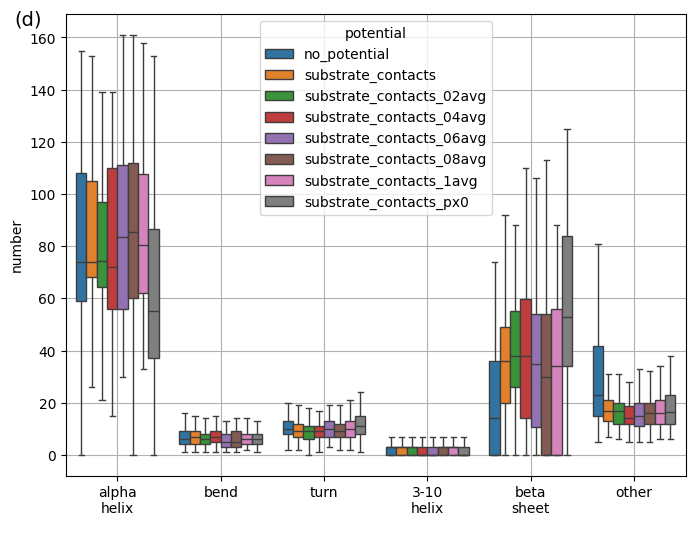

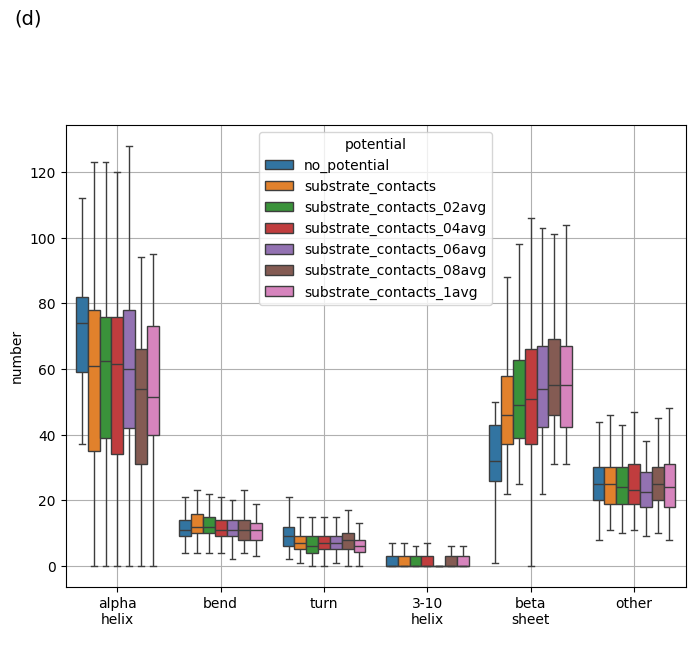

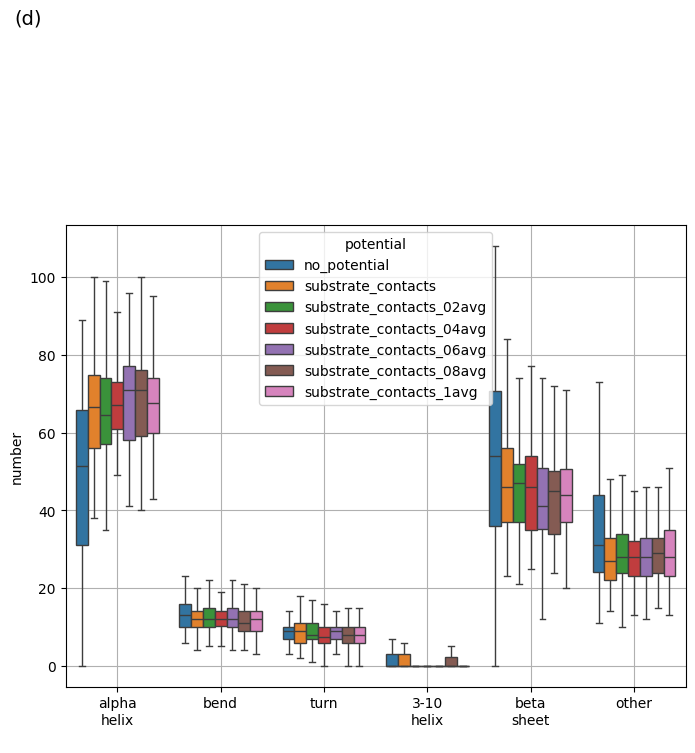

In [39]:
for motif in ['de_novo','site','binding']:
    plt.figure(figsize=(8,6))
    sns.boxplot(data=pd.melt(sec_df[sec_df.design_type==motif], 
                             id_vars=['name', 'protein', 'potential', 'design_type']), 
                x='variable', y='value', hue='potential', showfliers=False)
    #plt.xticks(rotation=45) 
    plt.xlabel('')
    plt.ylabel('number') 
    plt.grid()
    plt.text(-1, 165, '(d)', fontsize=14)
    plt.show()

## Boltz validation

In [ ]:
import warnings
from Bio.PDB.PDBParser import PDBParser 
from Bio.PDB.Superimposer import Superimposer
parser=PDBParser()
super=Superimposer()

warnings.simplefilter("ignore")
threshold=3
arr=[]
for motif in ['de_novo','site','binding']:
    for potential in na_pots:
        if not os.path.isdir(f'example_outputs/na/boltz_predictions/{motif}/{potential}/boltz_results_conf/predictions'):
            continue
        for file in tqdm.tqdm(os.listdir(f'example_outputs/na/boltz_predictions/{motif}/{potential}/boltz_results_conf/predictions')):
            pred=parser.get_structure('str',f'example_outputs/na/boltz_predictions/{motif}/{potential}/boltz_results_conf/predictions/{file}/{file}_model_0.pdb')
            packed=parser.get_structure('str',f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/{file}.pdb')
            a=[x['CA'] for x in pred[0]['A']]
            b=[x['CA'] for x in packed[0]['A']]
            super.set_atoms(a,b)
            with open(f'example_outputs/na/boltz_predictions/{motif}/{potential}/boltz_results_conf/predictions/{file}/confidence_{file}_model_0.json','r') as f:
                d=json.load(f)
            arr.append([file,potential, motif,super.rms,
                        d["confidence_score"],d["ptm"],d["iptm"],d["complex_plddt"],d["complex_iplddt"]])#,d['chains_ptm']["0"],d['pair_chains_iptm']["0"]["1"],d['pair_chains_iptm']["0"]["2"]])

align_df=pd.DataFrame(columns=['name','potential','design_type','rms','confidence_score','ptm','iptm','complex_plddt','complex_iplddt'], 
                      data=arr)
align_df

100%|██████████| 250/250 [01:36<00:00,  2.59it/s]


,name,potential,design_type,rms,confidence_score,ptm,iptm,complex_plddt,complex_iplddt
0,imsoi_33_2,no_potential,de_novo,5.746366,0.655043,0.751222,0.520691,0.688631,0.740250
1,imsoi_11_1,no_potential,de_novo,13.127056,0.521100,0.499081,0.349671,0.563957,0.706523
2,imsoi_49_1,no_potential,de_novo,13.133609,0.751973,0.823122,0.658343,0.775381,0.835806
3,imsoi_32_5,no_potential,de_novo,8.097296,0.705618,0.740077,0.628050,0.725010,0.775970
4,imsoi_2_4,no_potential,de_novo,20.041798,0.552205,0.649108,0.542693,0.554583,0.653325
...,...,...,...,...,...,...,...,...,...
1995,imsoi_3_4,na_contacts_px0,de_novo,1.951507,0.812020,0.871831,0.794843,0.816314,0.893182
1996,imsoi_46_4,na_contacts_px0,de_novo,6.049221,0.616759,0.656146,0.428634,0.663791,0.830141
1997,imsoi_23_2,na_contacts_px0,de_novo,2.647951,0.669880,0.773984,0.514431,0.708742,0.815693
1998,imsoi_22_5,na_contacts_px0,de_novo,9.296144,0.666407,0.834082,0.713346,0.654672,0.796042


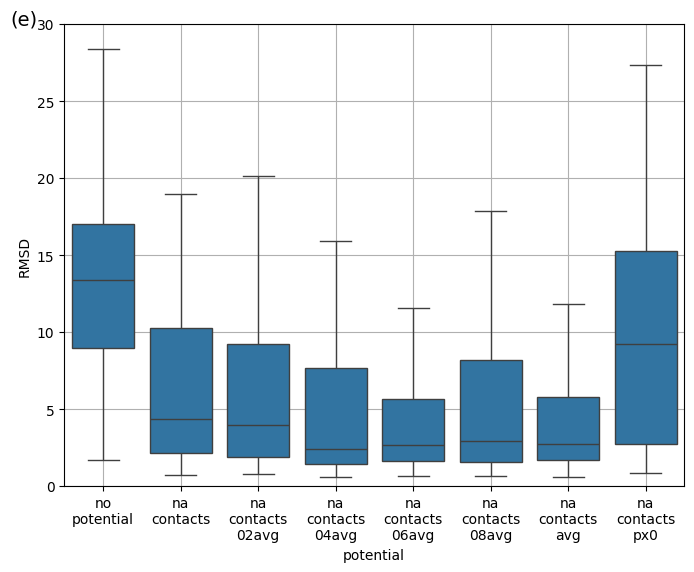

In [43]:
align_df.potential=align_df.potential.apply(lambda x: x.replace('_','\n'))

for i, motif in enumerate(['de_novo']):#,'site','binding']):
    plt.figure(figsize=(8,6))
    plt.text(-1.2, 30, '(e)', fontsize=14)

    sns.boxplot(x="potential", y="rms", hue="design_type",
                data=align_df[align_df.design_type==motif], showfliers=False)
    plt.xlabel('potential')
    plt.ylabel('RMSD')
    plt.ylim(0,30)

    plt.legend().set_visible(False)
    plt.grid()
    plt.show()

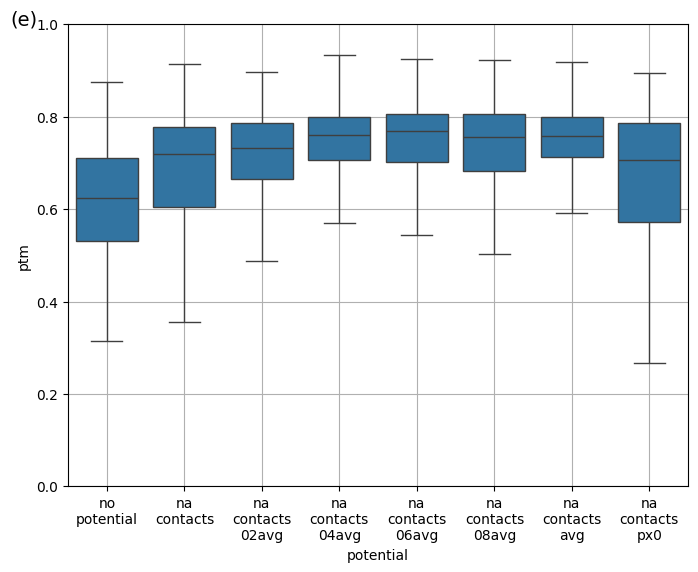

In [45]:

for i, motif in enumerate(['de_novo']):#,'site','binding']):
    plt.figure(figsize=(8,6))
    plt.text(-1.25, 1, '(e)', fontsize=14)

    sns.boxplot(x="potential", y="ptm", hue="design_type",
                data=align_df[align_df.design_type==motif], showfliers=False)
    plt.xlabel('potential')
    plt.ylim(0,1)

    plt.legend().set_visible(False)
    plt.grid()
    plt.show()

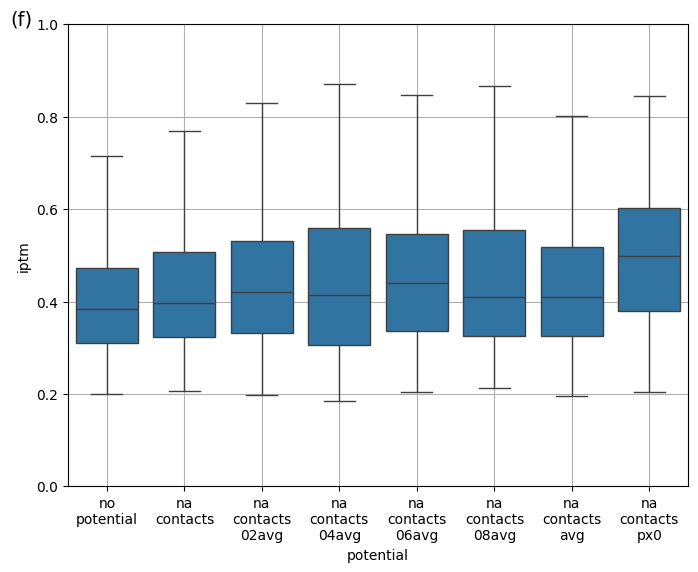

In [47]:

for i, motif in enumerate(['de_novo']):#,'site','binding']):
    plt.figure(figsize=(8,6))
    plt.text(-1.25, 1, '(f)', fontsize=14)

    sns.boxplot(x="potential", y="iptm", hue="design_type",
                data=align_df[align_df.design_type==motif], showfliers=False)
    plt.xlabel('potential')
    plt.ylim(0,1)

    plt.legend().set_visible(False)
    plt.grid()
    plt.show()

In [ ]:
import warnings
from Bio.PDB.PDBParser import PDBParser 
from Bio.PDB.Superimposer import Superimposer
parser=PDBParser()
super=Superimposer()

warnings.simplefilter("ignore")
threshold=3
arr=[]
for motif in ['site','binding']:
    for potential in na_pots[:2]:
        if not os.path.isdir(f'example_outputs/na/boltz_predictions/{motif}/{potential}/boltz_results_conf/predictions'):
            continue
        for file in tqdm.tqdm(os.listdir(f'example_outputs/na/boltz_predictions/{motif}/{potential}/boltz_results_conf/predictions')):
            pred=parser.get_structure('str',f'example_outputs/na/boltz_predictions/{motif}/{potential}/boltz_results_conf/predictions/{file}/{file}_model_0.pdb')
            packed=parser.get_structure('str',f'example_outputs/na/proteinmpnn_output/{motif}/{potential}/relaxed/{file}.pdb')
            a=[x['CA'] for x in pred[0]['A']]
            b=[x['CA'] for x in packed[0]['A']]
            super.set_atoms(a,b)
            with open(f'example_outputs/na/boltz_predictions/{motif}/{potential}/boltz_results_conf/predictions/{file}/confidence_{file}_model_0.json','r') as f:
                d=json.load(f)
            arr.append([file,potential, motif,super.rms,
                        d["confidence_score"],d["ptm"],d["iptm"],d["complex_plddt"],d["complex_iplddt"]])#,d['chains_ptm']["0"],d['pair_chains_iptm']["0"]["1"],d['pair_chains_iptm']["0"]["2"]])

align_df=pd.DataFrame(columns=['name','potential','design_type','rms','confidence_score','ptm','iptm','complex_plddt','complex_iplddt'], 
                      data=arr)



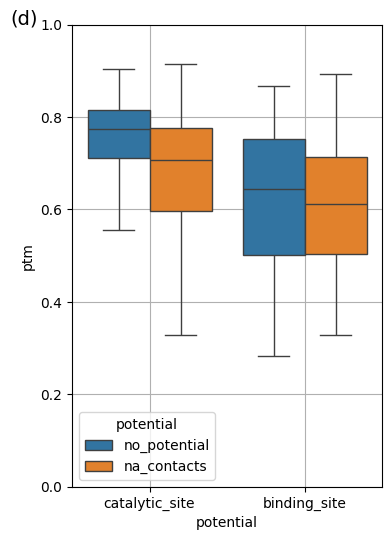

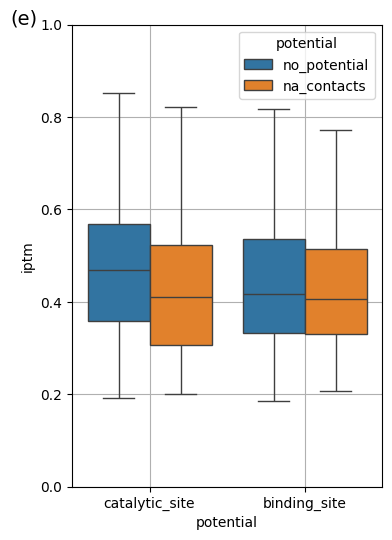

In [74]:

plt.figure(figsize=(4,6))
#plt.title(motif)
sns.boxplot(x="design_type", y="ptm", hue='potential',
                data=align_df, legend='full', showfliers=False)
plt.xlabel('potential')
plt.ylim(0,1)
plt.grid()
plt.xticks(ticks=[0,1],labels=['catalytic_site','binding_site'])
plt.text(-0.9, 1, '(d)', fontsize=14)

plt.show()

plt.figure(figsize=(4,6))
#plt.title(motif)
sns.boxplot(x="design_type", y="iptm", hue='potential',
                data=align_df, legend='full', showfliers=False)
plt.xlabel('potential')
plt.ylim(0,1)
plt.grid()
plt.xticks(ticks=[0,1],labels=['catalytic_site','binding_site'])
plt.text(-0.9, 1, '(e)', fontsize=14)

plt.show()